####  Responsible Text Analysis: From Raw Speeches to Robust Inference

 **Learning goals**

 - See how modeling choices (preprocessing, thresholds, algorithms, hyper-params) change results.

 - Run *multiple* sentiment models and compare conclusions.

 - Tune topic modeling (UMAP/HDBSCAN) transparently and save artifacts.

 - Regress sentiment on topics + covariates and assess robustness (agreement/disagreement across models).

 - Log decisions for reproducibility (avoid p-hacking; enable preregistration-style summaries).

 **Data source: ParlaMint EU Parliament proceedings**

 - Transcripts of speeches from 29 European countries in their native languages. Here we use United Kingdom (English).

 - Rich contextual metadata (date, role, party, country, debate topic).

 - Publicly available: https://www.clarin.si/repository/xmlui/handle/11356/2005

 **Data caveats to discuss in class**

 - What is the source and fidelity of the transcripts? (OCR? edited?)

 - Contextual metadata (date, role, party) is **not** the text; we model both.

 - Long speeches get truncated by transformer models unless handled carefully.

 - Topic models are unstable: different random seeds / params → different clusters.



 **Artifacts written**

 - `artifacts/decision_log.json`

 - `artifacts/parlamint_selected.csv` (post-filter)

 - `artifacts/enriched_sentiment.csv` (after each model, columns appended)

 - `artifacts/embeddings.npy`

 - `artifacts/hdbscan_tuning_results.csv`

 - `artifacts/enriched_with_topics.csv` (topic ids, names, dummies)

 - `figures/*` (EDA, distributions, model comparisons)

In [1]:
import os, json, ast, textwrap
from pathlib import Path
from math import ceil
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd

import torch
from tqdm import tqdm

# Sentiment tools

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pysentiment2 as ps
from transformers import pipeline

# Topic modeling

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Modeling & plots

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

In [2]:
# Reproducibility (note: UMAP/HDBSCAN still have stochasticity)

SEED = 42
np.random.seed(SEED)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Paths

DATA_DIR = Path("./data")
ART_DIR = Path("./artifacts"); ART_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

CSV_INPUT = ART_DIR / "parlamint_gb_commons.csv"             # provided CSV
CSV_SELECTED = ART_DIR / "parlamint_selected.csv"
CSV_ENRICHED = ART_DIR / "enriched_sentiment.csv"
CSV_TOPICS = ART_DIR / "enriched_with_topics.csv"
EMB_PATH = ART_DIR / "embeddings.npy"
TUNE_PATH = ART_DIR / "hdbscan_tuning_results.csv"
TOPIC_MODEL_PATH = ART_DIR / "bertopic_model"
DECISION_LOG = ART_DIR / "decision_log.json"

# Lightweight embedding model for class demo (can swap to all-mpnet-base-v2)

EMB_MODEL = "all-MiniLM-L6-v2"

# Transformer sentiment models

MODEL_PARLASENT = "classla/xlm-r-parlasent"
MODEL_TWITTER = "cardiffnlp/twitter-roberta-base-sentiment-latest"
MODEL_FINBERT = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

DEVICE = 0 if torch.cuda.is_available() else -1

In [3]:
@dataclass
class Decisions:
    min_words: int = 50
    max_words: int = 2000
    include_roles: dict = None
    exclude_chair_ministers: bool = True
    truncation_strategy: str = "truncate_to_512"  # NOTE: discuss bias!
    embedding_model: str = EMB_MODEL
    topic_umap_n_components: int = 5
    topic_metric: str = "euclidean"
    comment: str = "Class demo; emphasize pitfalls and robustness."

def load_decisions() -> Decisions:
    if DECISION_LOG.exists():
        try:
            return Decisions(**json.loads(DECISION_LOG.read_text()))
        except Exception:
            pass

    d = Decisions(
        include_roles={"Speaker_MP": "MP", "Speaker_role": "Regular", "Speaker_minister": "notMinister"}
        )

    save_decisions(d)
    return d

def save_decisions(d: Decisions):
    DECISION_LOG.write_text(json.dumps(asdict(d), indent=2))

DECISIONS = load_decisions()

def log_note(key: str, value):
    """Append/update a decision or note in the decision log."""
    cur = json.loads(DECISION_LOG.read_text())
    cur[key] = value
    DECISION_LOG.write_text(json.dumps(cur, indent=2))

def save_csv(df: pd.DataFrame, path: Path, note: str):
    df.to_csv(path, index=False)
    print(f"[saved] {note} → {path}")

In [4]:
# ========== 1) Load data (from provided CSV) ==========
def load_parlamint(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path, dtype="string", encoding="utf-8", parse_dates=["Date"])
    return df

all_data = load_parlamint(CSV_INPUT)
print(all_data.head(3))

                                   ID  \
0  ParlaMint-GB_2021-01-06-commons.u1   
1  ParlaMint-GB_2021-01-06-commons.u2   
2  ParlaMint-GB_2021-01-06-commons.u3   

                                                Text  \
0  Before we come to the first item of business, ...   
1  Mr Speaker, I share your gratitude to the Hous...   
2  I thank the Prime Minister for advance sight o...   

                           Text_ID Title       Date         Body Term Session  \
0  ParlaMint-GB_2021-01-06-commons  <NA> 2021-01-06  Lower house   58       -   
1  ParlaMint-GB_2021-01-06-commons  <NA> 2021-01-06  Lower house   58       -   
2  ParlaMint-GB_2021-01-06-commons  <NA> 2021-01-06  Lower house   58       -   

  Meeting     Sitting  ... Speaker_MP Speaker_minister Speaker_party  \
0    <NA>  2021-01-06  ...         MP      notMinister           LAB   
1    <NA>  2021-01-06  ...         MP      notMinister           CON   
2    <NA>  2021-01-06  ...         MP      notMinister           LAB 

Missing values:
 ID                        0
Text                      0
Text_ID                   0
Title                 47245
Date                      0
Body                      0
Term                      0
Session                   0
Meeting               47245
Sitting                   0
Agenda                    0
Subcorpus                 0
Lang                      0
Speaker_role              0
Speaker_MP                0
Speaker_minister          0
Speaker_party             0
Speaker_party_name        0
Party_status              0
Party_orientation         0
Speaker_ID                0
Speaker_name              0
Speaker_gender            0
Speaker_birth             0
dtype: int64

[ID: ParlaMint-GB_2021-09-21-commons.u307, Date: 2021-09-21 00:00:00, Speaker: Cunningham, Alexander]
The hon. Member makes me reflect on a family matter of my own. When my grandad
was killed in a pit accident, my dad had his apprenticeship, and my granny went
out and scrubbed floors to ensure th

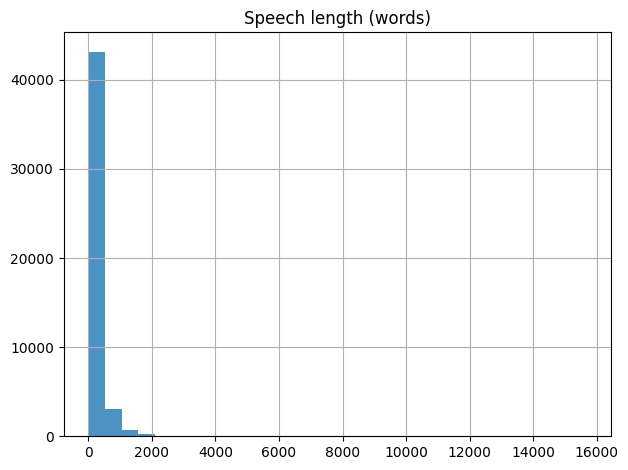

In [5]:
# ========== 2) Quick EDA & sanity checks ==========

def random_read(df: pd.DataFrame, n=3, width=80):
    samp = df.sample(n, random_state=SEED)
    for _, r in samp.iterrows():
        print(f"\n[ID: {r.get('ID')}, Date: {r.get('Date')}, Speaker: {r.get('Speaker_name')}]")
        print(textwrap.fill(str(r.get("Text", ""))[:500], width=width))

print("Missing values:\n", all_data.isna().sum())
random_read(all_data, n=2)

# Length features

all_data["len_chars"] = all_data["Text"].str.len().astype("Int64")
all_data["len_words"] = all_data["Text"].str.split().str.len().astype("Int64")
all_data["len_sentences_est"] = all_data["Text"].str.split(r"[.!?]+").str.len().astype("Int64")

# Save simple histograms

def hist_series(s, title, fname):
    plt.figure()
    s.dropna().astype(float).hist(bins=30, alpha=0.8)
    plt.title(title); plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=140)
    plt.show()
    plt.close()

hist_series(all_data["len_words"], "Speech length (words)", "len_words_hist.png")

Selected 31186 / 47245 speeches after filters.
[saved] post-filter speeches → artifacts\parlamint_selected.csv


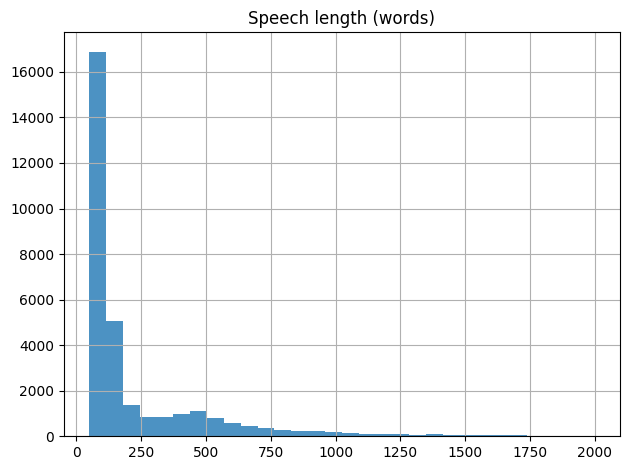

In [ ]:
# ========== 3) Transparent preprocessing and filtering decisions ==========

def apply_filters(df: pd.DataFrame, decisions: Decisions) -> pd.DataFrame:
    df = df.copy()
    # Length
    df = df[df["len_words"] >= decisions.min_words]
    df = df[df["len_words"] <= decisions.max_words]
    # Role filters
    inc = decisions.include_roles or {}
    for k, v in inc.items():
        if k in df.columns:
            df = df[df[k] == v]
        if decisions.exclude_chair_ministers:
        # already captured above with 'Regular' and 'notMinister', but leave as guard rails
            pass
    return df

selected = apply_filters(all_data, DECISIONS)
print(f"Selected {len(selected)} / {len(all_data)} speeches after filters.")
save_csv(selected, CSV_SELECTED, "post-filter speeches")
log_note("n_selected", int(len(selected)))

hist_series(selected["len_words"], "Speech length (words)", "len_words_hist_selected.png")

In [ ]:
# ========== 4) Sentiment models with caching ==========

# - Show differences across rule-based, lexicon, and transformer models.

# - Normalize outputs to a common polarity scale [-1, 1] (where feasible).

# - Save after each model to illustrate incremental analysis.

vader = SentimentIntensityAnalyzer()
harvard_dict = ps.HIV4()
fin_dict = ps.LM()

def add_vader(text: str) -> float:
    return float(vader.polarity_scores(text)["compound"])

def add_textblob(text: str) -> float:
    return float(TextBlob(text).sentiment.polarity)

def add_dict_polarity(text: str, dictionary) -> float:
    try:
        score = dictionary.get_score(dictionary.tokenize(text))
        return float(score.get("Polarity"))
    except Exception:
        return np.nan

def probs_to_polarity(dist):
# dist like: [{'label': 'negative', 'score': ...}, ...]
    probs = {"neg":0.0, "neu":0.0, "pos":0.0}
    for d in dist:
        lab = d["label"].lower(); sc = float(d["score"])
        if "neg" in lab: probs["neg"] += sc
        elif "neu" in lab: probs["neu"] += sc
        elif "pos" in lab: probs["pos"] += sc
    return probs["pos"] - probs["neg"]

def normalize_parlasent(score: float, lo=0.0, hi=5.0) -> float:
    # ParlaSent originally ~[0,5]; map to [-1,1], clamp to avoid >1 from regression heads
    z = -1 + 2 * ((float(score) - lo) / (hi - lo))
    return max(-1.0, min(1.0, z))

def run_batches(pipe, texts, bsz=16, desc="", return_all_scores=False):
    out, n_batches = [], ceil(len(texts)/bsz)
    for i in tqdm(range(n_batches), desc=desc):
        batch = texts[i*bsz:(i+1)*bsz]
        out.extend(pipe(batch, return_all_scores=return_all_scores))
    return out

def ensure_enriched(base: pd.DataFrame) -> pd.DataFrame:
    if CSV_ENRICHED.exists():
        df = pd.read_csv(CSV_ENRICHED)
        print(f"[loaded] enriched with shape {df.shape}")
        return df
    base.to_csv(CSV_ENRICHED, index=False)
    return base.copy()

enriched = ensure_enriched(selected)

texts = enriched["Text"].astype(str).tolist()

# 4.1 VADER

if "vader" not in enriched.columns:
    enriched["vader"] = [add_vader(t) for t in tqdm(texts, desc="VADER")]
    save_csv(enriched, CSV_ENRICHED, "VADER added")

# 4.2 TextBlob

if "textblob" not in enriched.columns:
    enriched["textblob"] = [add_textblob(t) for t in tqdm(texts, desc="TextBlob")]
    save_csv(enriched, CSV_ENRICHED, "TextBlob added")

# 4.3 Dictionaries

if "fin_polarity" not in enriched.columns:
    enriched["fin_polarity"] = [add_dict_polarity(t, fin_dict) for t in tqdm(texts, desc="LM Dictionary")]
    save_csv(enriched, CSV_ENRICHED, "LM dictionary polarity added")

if "harv_polarity" not in enriched.columns:
    enriched["harv_polarity"] = [add_dict_polarity(t, harvard_dict) for t in tqdm(texts, desc="Harvard IV")]
    save_csv(enriched, CSV_ENRICHED, "Harvard dictionary polarity added")

# 4.4 Transformers (note truncation!)

pipes = {}
def get_pipe(name, model_name):
    if name in pipes: return pipes[name]
    p = pipeline("sentiment-analysis", model=model_name,
            batch_size=4, truncation=True, padding=True,
            max_length=512, device=DEVICE)
    pipes[name] = p
    return p

# ParlaSent (regression-like)

if "parla_polarity" not in enriched.columns:
    out = run_batches(get_pipe("parla", MODEL_PARLASENT), texts, bsz=4, desc="ParlaSent")
# ParlaSent returns {"label": "...", "score": value_in_0_5}
    enriched["parla_polarity"] = [normalize_parlasent(o["score"]) for o in out]
    save_csv(enriched, CSV_ENRICHED, "ParlaSent polarity added")
    log_note("transformer_truncation", DECISIONS.truncation_strategy)

# Twitter RoBERTa (3-way)

if "twitter_polarity" not in enriched.columns:
    out = run_batches(get_pipe("twitter", MODEL_TWITTER), texts, bsz=4, desc="Twitter", return_all_scores=True)
    enriched["twitter_polarity"] = [probs_to_polarity(d) for d in out]
    save_csv(enriched, CSV_ENRICHED, "Twitter polarity added")

# FinBERT (3-way)

if "finbert_polarity" not in enriched.columns:
    out = run_batches(get_pipe("finbert", MODEL_FINBERT), texts, bsz=4, desc="FinBERT", return_all_scores=True)
    enriched["finbert_polarity"] = [probs_to_polarity(d) for d in out]
    save_csv(enriched, CSV_ENRICHED, "FinBERT polarity added")

# Simple distribution plot (all in one)

plt.figure(figsize=(8,5))
for col in ["vader","textblob","fin_polarity","harv_polarity","parla_polarity","twitter_polarity","finbert_polarity"]:
    enriched[col].dropna().plot(kind="kde", alpha=0.7)
plt.title("Sentiment distributions (different models)"); plt.tight_layout()
plt.legend()
plt.savefig(FIG_DIR / "sentiment_distributions_kde.png", dpi=140); plt.close()

[loaded] enriched with shape (31186, 34)


In [8]:
docs = enriched["Text"].astype(str).tolist()

def get_embeddings(docs, model_name: str, path: Path) -> np.ndarray:
    """Load or compute & save embeddings for a list of documents."""
    if path.exists():
        emb = np.load(path)
        print(f"[loaded] embeddings {emb.shape}")
        return emb
    model = SentenceTransformer(model_name)
    emb = model.encode(docs, show_progress_bar=True, normalize_embeddings=True)
    np.save(path, emb)
    print(f"[saved] embeddings {emb.shape} → {path}")
    return emb

embeddings = get_embeddings(docs, DECISIONS.embedding_model, EMB_PATH)

def compute_coherence(topic_model, docs, topk=10, measure="c_v"):
    """Compute topic coherence using Gensim's CoherenceModel"""
    topics = topic_model.get_topics()
    topic_words = [[w for w,_ in topic[:topk]] for _, topic in topics.items()]
    tokenized = [d.split() for d in docs]
    dictionary = Dictionary(tokenized)
    cm = CoherenceModel(topics=topic_words, texts=tokenized, dictionary=dictionary, coherence=measure)
    return cm.get_coherence()

def compute_diversity(topic_model, topk=20):
    """Compute topic diversity: proportion of unique words across topics"""
    topics = topic_model.get_topics()
    all_words = [word for _, topic in topics.items() for word, _ in topic[:topk]]
    unique_words = len(set(all_words))
    total_words = len(topics) * topk if topics else 1
    return unique_words / total_words

# Parameter grid (kept compact for class; expand if time allows)
param_grid = [
    {"min_cluster_size": 10, "min_samples": 2,  "neighbors": 15},
    {"min_cluster_size": 10, "min_samples": 10, "neighbors": 15},
    {"min_cluster_size": 50, "min_samples": 5,  "neighbors": 15},
    {"min_cluster_size": 50, "min_samples": 50, "neighbors": 15},
    {"min_cluster_size": 100, "min_samples": 10, "neighbors": 15},
    {"min_cluster_size": 100, "min_samples": 100,"neighbors": 15},
    ]

if TUNE_PATH.exists():
    tuning = pd.read_csv(TUNE_PATH)
    print("[loaded] HDBSCAN tuning results")
else:
    results = []
    for params in tqdm(param_grid, desc="HDBSCAN tuning"):
        hdb = HDBSCAN(min_cluster_size=params["min_cluster_size"],
            min_samples=params["min_samples"],
            metric=DECISIONS.topic_metric,
            cluster_selection_method="eom")
        
        umap = UMAP(n_components=DECISIONS.topic_umap_n_components,
            n_neighbors=params["neighbors"], random_state=SEED)
        
        tm = BERTopic(embedding_model=None, umap_model=umap, hdbscan_model=hdb,
            calculate_probabilities=False, verbose=False)
            
        topics, _ = tm.fit_transform(docs, embeddings)
        coh = compute_coherence(tm, docs)
        div = compute_diversity(tm)
        n_topics = len(set(topics)) - (1 if -1 in topics else 0)
        results.append({"params": params, "coherence": coh, "diversity": div, "n_topics": n_topics})
    tuning = pd.DataFrame(results)
    tuning.to_csv(TUNE_PATH, index=False)
    print("[saved] tuning results →", TUNE_PATH)

# Pick a "best" row (simple weighted score; adjust live in class)
tuning["score"] = tuning["coherence"].rank(pct=True) * 0.5 + tuning["diversity"].rank(pct=True) * 0.5
best_row = tuning.sort_values("score", ascending=False).iloc[0]
best_params = ast.literal_eval(str(best_row["params"]))
print("Best params:", best_params)

plt.figure(figsize=(7,4))
sns.scatterplot(data=tuning, x="coherence", y="diversity", size="n_topics")
plt.title("Tuning tradeoff: coherence vs diversity"); plt.tight_layout()
plt.savefig(FIG_DIR / "hdbscan_tuning_scatter.png", dpi=140); plt.close()

# Fit final BERTopic
if TOPIC_MODEL_PATH.exists():
    topic_model = BERTopic.load(TOPIC_MODEL_PATH)
    print(f"[loaded] BERTopic model → {TOPIC_MODEL_PATH}")
    topics, probs = topic_model.transform(docs, embeddings)
else:
    hdb_final = HDBSCAN(min_cluster_size=best_params["min_cluster_size"],
        min_samples=best_params["min_samples"],
        metric=DECISIONS.topic_metric,
        cluster_selection_method="eom",
        prediction_data=True)

    umap_final = UMAP(n_components=DECISIONS.topic_umap_n_components,
    n_neighbors=best_params["neighbors"], random_state=SEED)

    topic_model = BERTopic(embedding_model=None, umap_model=umap_final,
        hdbscan_model=hdb_final, calculate_probabilities=True, verbose=False)
        
    topics, probs = topic_model.fit_transform(docs, embeddings)

topic_info = topic_model.get_topic_info()
id2name = {r["Topic"]: r["Name"] for r in topic_info.to_dict(orient="records")}

enriched["topic"] = topics
enriched["topic_prob"] = [float(max(p)) if isinstance(p, (list, np.ndarray)) else 0.0 for p in probs]
enriched["topic_name"] = [id2name.get(t, "Outlier") for t in topics]

# Optional: reduce outliers based on embeddings

new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
enriched["topic_merged"] = new_topics

# One-hot for top 10 topics + Rest + Outlier

top10 = (enriched.loc[enriched["topic"]>=0,"topic_name"].value_counts().nlargest(10).index)
grp = enriched["topic_name"].copy()
grp[~enriched["topic_name"].isin(top10) & (enriched["topic"]>=0)] = "Rest"
grp[enriched["topic"]<0] = "Outlier"
enriched["topic_group"] = grp
topic_dummies = pd.get_dummies(enriched["topic_group"], prefix="", prefix_sep="")
enriched = pd.concat([enriched, topic_dummies], axis=1)

save_csv(enriched, CSV_TOPICS, "topics added (ids, names, dummies)")

# Save final topic model
topic_model.save(TOPIC_MODEL_PATH)
print(f"[saved] BERTopic model → {TOPIC_MODEL_PATH}")

[loaded] embeddings (31186, 768)


HDBSCAN tuning: 100%|██████████| 6/6 [08:05<00:00, 80.92s/it] 


[saved] tuning results → artifacts\hdbscan_tuning_results.csv
Best params: {'min_cluster_size': 50, 'min_samples': 5, 'neighbors': 15}
[loaded] BERTopic model → artifacts\bertopic_model


2025-10-14 19:38:39,270 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


[saved] topics added (ids, names, dummies) → artifacts\enriched_with_topics.csv
[saved] BERTopic model → artifacts\bertopic_model


In [9]:
enriched.columns

Index(['ID', 'Text', 'Text_ID', 'Title', 'Date', 'Body', 'Term', 'Session',
       'Meeting', 'Sitting', 'Agenda', 'Subcorpus', 'Lang', 'Speaker_role',
       'Speaker_MP', 'Speaker_minister', 'Speaker_party', 'Speaker_party_name',
       'Party_status', 'Party_orientation', 'Speaker_ID', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', 'len_chars', 'len_words',
       'len_sentences_est', 'vader', 'textblob', 'fin_polarity',
       'harv_polarity', 'parla_polarity', 'twitter_polarity',
       'finbert_polarity', 'topic', 'topic_prob', 'topic_name', 'topic_merged',
       'topic_group', '0_vaccine_vaccination_we_the',
       '1_afghanistan_taliban_afghan_who',
       '2_leaseholders_safety_building_buildings',
       '3_forces_armed_veterans_service', '4_climate_cop26_zero_net',
       '5_care_social_tax_will', '6_aid_07_world_cuts',
       '7_asylum_refugees_seekers_people', '8_credit_universal_cut_poverty',
       '9_ireland_northern_protocol_agreement', 'Outlier', 'Rest'],


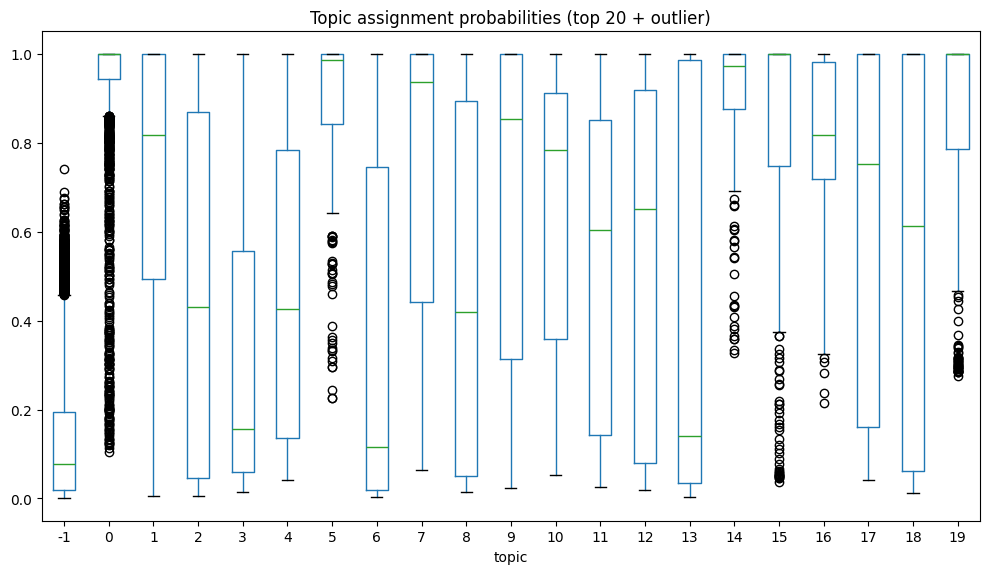

In [10]:
df_top10 = enriched[enriched['topic'].isin(list(range(20)) + [-1])]
df_top10.boxplot(column='topic_prob', by='topic', figsize=(10,6), grid=False)
plt.title("Topic assignment probabilities (top 20 + outlier)"); plt.suptitle(''); plt.tight_layout()
plt.savefig(FIG_DIR / "topic_prob_boxplot.png", dpi=140)
plt.show()
plt.close()

In [11]:
topic_model.visualize_topics()

In [12]:
topic_model.visualize_hierarchy()

          Sentiment           AIC           BIC    adj_R2        n
1          textblob -38960.984321 -38718.900308  0.055091  31186.0
3     harv_polarity  15307.812930  15549.896942  0.072848  31186.0
5  twitter_polarity  46060.520963  46302.604975  0.166108  31186.0
6  finbert_polarity  53041.794034  53283.878046  0.120418  31186.0
0             vader  57983.892204  58225.976217  0.104819  31186.0


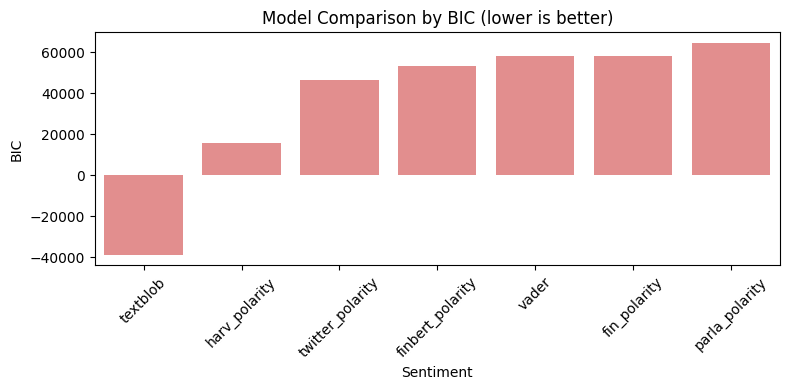

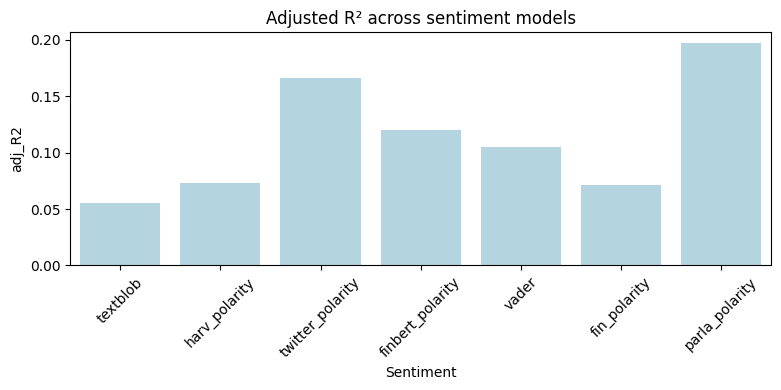

In [15]:
# ========== 6) Regression: what drives sentiment? ==========

# Compare across sentiment measures to reveal instability/robustness.

sentiments = ["vader","textblob","fin_polarity","harv_polarity","parla_polarity","twitter_polarity","finbert_polarity"]

# Covariates (adapt if columns differ)

base_covariates = ["Speaker_party_name","Party_status","Party_orientation","Speaker_gender","len_words"]
topic_cols = ["Outlier","Rest"] + [c for c in topic_dummies.columns if c not in ["Outlier","Rest"]][:10]  # keep top 10 + buckets

# Prepare X

X_base = pd.get_dummies(enriched[base_covariates], drop_first=True)
X = pd.concat([X_base, enriched[topic_cols]], axis=1).fillna(0.0)
X = X.apply(lambda c: c.astype(float))
X = sm.add_constant(X)

results = {}
coef_frames = []

for y_col in sentiments:
    y = pd.to_numeric(enriched[y_col], errors="coerce")
    model_data = pd.concat([y, X], axis=1).dropna()

    y_clean = model_data[y_col]
    X_clean = model_data.drop(columns=y_col)

    # HC3 robust SE to limit heteroskedasticity worries
    model = sm.OLS(y_clean, X_clean).fit(cov_type="HC3")

    # p-value correction per model (Bonferroni) then across sentiments (meta-FDR below)
    pvals = model.pvalues
    pvals_bonf = multipletests(pvals, method="bonferroni")[1]

    results[y_col] = {
        "AIC": model.aic, "BIC": model.bic, "adj_R2": model.rsquared_adj,
        "n": int(y_clean.shape[0])
    }

    cdf = model.params.to_frame("coef").join(model.conf_int().rename(columns={0:"lower",1:"upper"}))
    cdf["p"] = pvals
    cdf["p_bonf"] = pvals_bonf
    cdf["significant"] = cdf["p_bonf"] < 0.05
    cdf["Sentiment"] = y_col
    cdf = cdf.reset_index().rename(columns={"index":"Variable"})
    coef_frames.append(cdf)

coef_all = pd.concat(coef_frames, ignore_index=True)
summary = pd.DataFrame(results).T.reset_index().rename(columns={"index":"Sentiment"})
summary = summary.sort_values("BIC")
print(summary.head())

summary.to_csv(ART_DIR / "model_summary.csv", index=False)
coef_all.to_csv(ART_DIR / "coefficients_all.csv", index=False)

# Diagnostics: BIC & Adj R2

plt.figure(figsize=(8,4))
sns.barplot(data=summary, x="Sentiment", y="BIC", color="lightcoral")
plt.title("Model Comparison by BIC (lower is better)"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(FIG_DIR / "bic_comparison.png", dpi=140)
plt.show()
plt.close()

plt.figure(figsize=(8,4))
sns.barplot(data=summary, x="Sentiment", y="adj_R2", color="lightblue")
plt.title("Adjusted R² across sentiment models"); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(FIG_DIR / "adjr2_comparison.png", dpi=140)
plt.show()
plt.close()

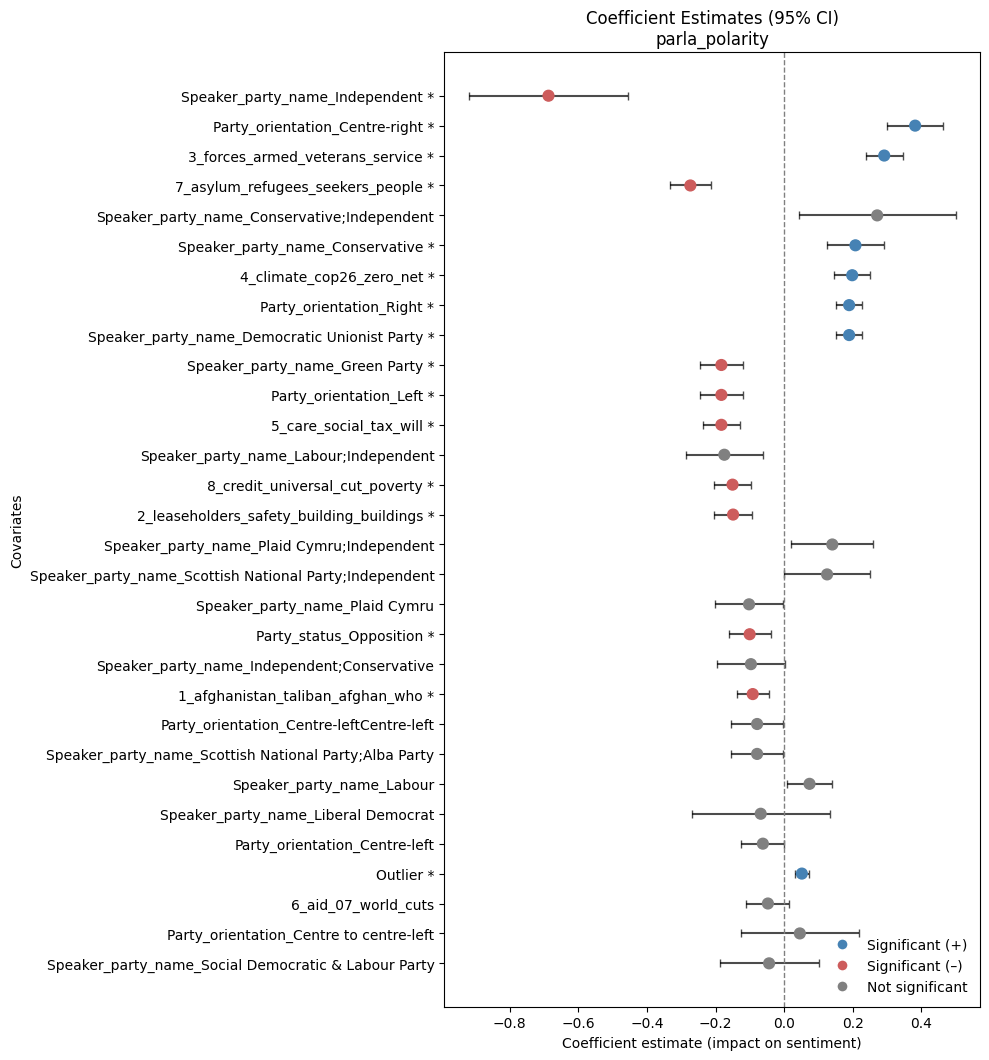

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coefficients_for_sentiment(coef_all, sentiment_name, top_n=None):
    """
    Plots coefficient estimates with 95% confidence intervals for a given sentiment model.
    Highlights statistical significance and direction.

    Parameters:
    - coef_all: DataFrame from regression results (includes coef, CIs, significant flag)
    - sentiment_name: str, the sentiment column name (e.g. 'vader')
    - top_n: int, optional, number of variables to show (largest absolute effects)
    """
    data = coef_all[coef_all['Sentiment'] == sentiment_name].copy()
    data = data[data['Variable'] != 'const']
    
    # Sort by absolute coefficient size
    data = data.reindex(data['coef'].abs().sort_values(ascending=False).index)
    
    # Optionally limit to top N
    if top_n:
        data = data.head(top_n)
    
    # Append asterisk to significant variable labels
    data['Variable_label'] = np.where(data['significant'], data['Variable'] + ' *', data['Variable'])
    
    # Colors by significance + direction
    data['color'] = np.where(
        data['significant'],
        np.where(data['coef'] > 0, 'steelblue', 'indianred'),
        'gray'
    )
    
    plt.figure(figsize=(10, max(6, len(data) * 0.35)))
    
    # Error bars = 95% confidence intervals
    plt.errorbar(
        data['coef'], data['Variable_label'],
        xerr=[data['coef'] - data['lower'], data['upper'] - data['coef']],
        fmt='o', ecolor='black', capsize=3, markersize=5, color='black', alpha=0.7
    )
    
    # Colored dots (significance & direction)
    plt.scatter(data['coef'], data['Variable_label'], color=data['color'], s=60, zorder=3)
    
    # Reference line at zero (no effect)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    # Titles and labels
    plt.title(f"Coefficient Estimates with 95% CIs – {sentiment_name}")
    plt.xlabel("Coefficient estimate (impact on sentiment)")
    plt.ylabel("Covariates")
    plt.gca().invert_yaxis()  # largest coefficients at top
    
    # Legend for clarity
    legend_elems = [
        plt.Line2D([0], [0], marker='o', color='w', label='Significant (+)', markerfacecolor='steelblue', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Significant (–)', markerfacecolor='indianred', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Not significant', markerfacecolor='gray', markersize=8)
    ]
    plt.legend(handles=legend_elems, loc='lower right', frameon=False)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"coefficients_{sentiment_name}.png", dpi=140)
    plt.title(f"Coefficient Estimates (95% CI)\n{sentiment_name}")
    plt.show()
    plt.close()


plot_coefficients_for_sentiment(coef_all, sentiment_name="parla_polarity", top_n=30)


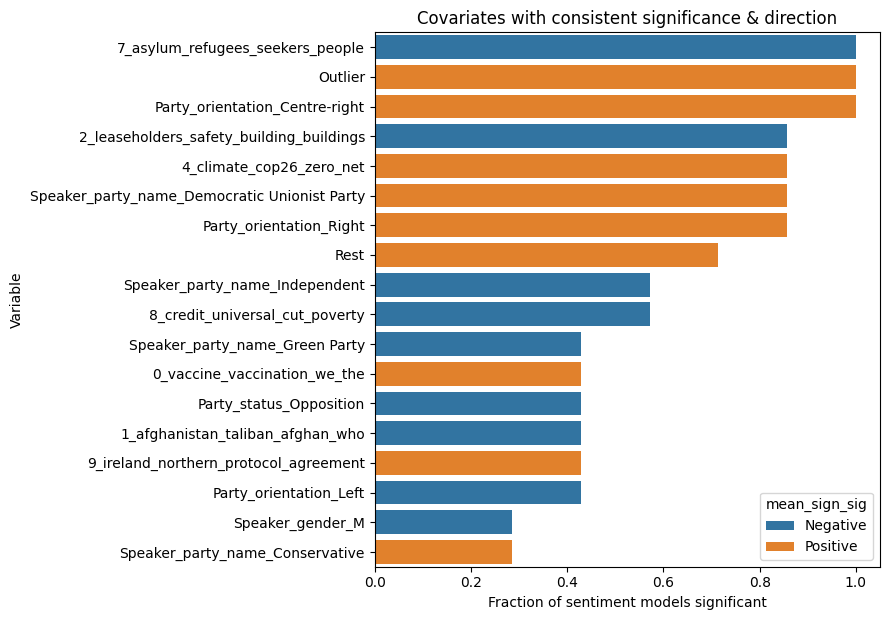

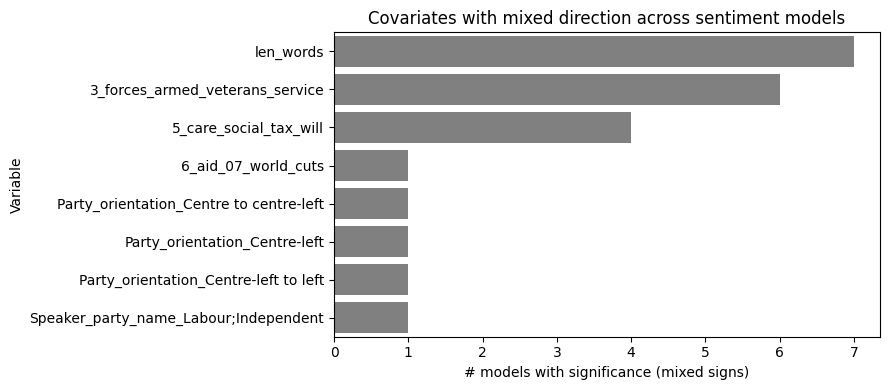

In [24]:
# ========== 7) Robustness lens: agreement vs disagreement ==========

coef_no_const = coef_all[coef_all["Variable"]!="const"].copy()

agg = (
    coef_no_const.groupby("Variable")
    .apply(lambda g: pd.Series({
    "n_sig": int((g["significant"]).sum()),
    "n_total": g["Sentiment"].nunique(),
    "mean_sign_sig": np.sign(g.loc[g["significant"], "coef"]).mean() if g["significant"].any() else 0.0,
    "signs_consistent": (len(set(np.sign(g.loc[g["significant"], "coef"]))) <= 1) if g["significant"].any() else True,
    "coef_mean": g["coef"].mean(),
    "coef_sd": g["coef"].std()
    }))
    .reset_index()
)

agg["frac_sig"] = agg["n_sig"] / agg["n_total"]
agg["agreement_status"] = np.where(
    (agg["n_sig"] >= 2) & (agg["signs_consistent"]), "Agreement",
    np.where(agg["n_sig"] > 0, "Disagreement", "No significance")
)

agree_df = agg.query("agreement_status == 'Agreement'").sort_values("frac_sig", ascending=False)
disagree_df = agg.query("agreement_status == 'Disagreement'").sort_values("n_sig", ascending=False)

agree_df.to_csv(ART_DIR / "agreement_covariates.csv", index=False)
disagree_df.to_csv(ART_DIR / "disagreement_covariates.csv", index=False)

plt.figure(figsize=(9, max(4, len(agree_df)*0.35)))
sns.barplot(data=agree_df.head(25), x="frac_sig", y="Variable",
hue=np.sign(agree_df.head(25)["mean_sign_sig"]).map({1:"Positive",-1:"Negative",0:"Mixed"}),
dodge=False)
plt.title("Covariates with consistent significance & direction")
plt.xlabel("Fraction of sentiment models significant"); plt.tight_layout()
plt.savefig(FIG_DIR / "agreement_covariates.png", dpi=140);
plt.show()
plt.close()

plt.figure(figsize=(9, max(4, len(disagree_df)*0.35)))
sns.barplot(data=disagree_df.head(25), x="n_sig", y="Variable", color="gray")
plt.title("Covariates with mixed direction across sentiment models")
plt.xlabel("# models with significance (mixed signs)"); plt.tight_layout()
plt.savefig(FIG_DIR / "disagreement_covariates.png", dpi=140);
plt.show()
plt.close()

In [36]:
# ========== 8) Classroom prompts & “pitfalls” checklist (printed; also logged) ==========

pitfalls = {
    "Truncation bias": "Transformer inputs truncated to 512 tokens; long speeches lose content. Consider sentence-chunking + aggregation.",
    "Domain shift": "Twitter/finance models on parliamentary speeches → miscalibration likely.",
    "Lexicon limits": "Negation, irony, domain-specific terms can break lexicon polarity.",
    "Seed/hyperparams": "UMAP/HDBSCAN and topic counts vary with seed & neighbors; instability expected.",
    "Multiple testing": "Many predictors × many outcomes → correct p-values; report families of models, not single cherry-picked one.",
    "Post-treatment bias": "Topics derived from text used as regressors for sentiment also derived from text; be explicit on causal interpretation.",
    "Reporting": "Log every preprocessing/filtering choice; keep versioned artifacts.",
    "Robustness": "No single sentiment model is ground truth; compare across models, report agreement/disagreement."
    "\n\t\tOr, better yet, annotate a small set of domain-specific data for validation and choose the best model."
    "\n\t\tAlso, you can use those annotations to introduce statistically valid estimates and standard errors,"
    "\n\t\teven when the model annotations contain arbitrary non-random prediction errors and biases."
    "\n\t\t\thttps://github.com/kristinagligoric/cdi-tutorial (Python)"
    "\n\t\t\thttps://naokiegami.com/dsl/ (R)."
}

log_note("pitfalls", pitfalls)
print("— Pitfalls to discuss —")
for k,v in pitfalls.items(): print(f"* {k}: {v}")

— Pitfalls to discuss —
* Truncation bias: Transformer inputs truncated to 512 tokens; long speeches lose content. Consider sentence-chunking + aggregation.
* Domain shift: Twitter/finance models on parliamentary speeches → miscalibration likely.
* Lexicon limits: Negation, irony, domain-specific terms can break lexicon polarity.
* Seed/hyperparams: UMAP/HDBSCAN and topic counts vary with seed & neighbors; instability expected.
* Multiple testing: Many predictors × many outcomes → correct p-values; report families of models, not single cherry-picked one.
* Post-treatment bias: Topics derived from text used as regressors for sentiment also derived from text; be explicit on causal interpretation.
* Reporting: Log every preprocessing/filtering choice; keep versioned artifacts.
* Robustness: No single sentiment model is ground truth; compare across models, report agreement/disagreement.
		Or, better yet, annotate a small set of domain-specific data for validation and choose the best model.